Connected to SMAP (Python 3.11.5)

In [1]:
import os
import getpass

import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import Normalize
import datashader as ds
from datashader.mpl_ext import dsshow
from textwrap import wrap

from functions import q_drydown, exponential_drydown, loss_model, loss_sigmoid2

In [2]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Nonlinear parameter $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.6],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s50": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

In [3]:
# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

# Land cover
IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 588191


In [4]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Nonlinear parameter $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.6],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s50": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

In [5]:
# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

# Land cover
IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 588191


In [6]:
# Difference between R2 values of two models
df = df.assign(diff_R2=df["sigmoid_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from sigmoid model
df["sigmoid_ETmax_denormalized"] = df["sigmoid_k"] * (df["max_sm"] - df["min_sm"]) * z_mm

# Get the binned dataset

# sand bins
df["sand_bins"] = pd.cut(df["sand_fraction"], bins=sand_bin_list, include_lowest=True)
first_I = df["sand_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["sand_bins"] = df["sand_bins"].cat.rename_categories({first_I: new_I})

# ai_bins
df["ai_bins"] = pd.cut(df["AI"], bins=ai_bin_list, include_lowest=True)
first_I = df["ai_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["ai_bins"] = df["ai_bins"].cat.rename_categories({first_I: new_I})

In [7]:
# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)

In [8]:
# Difference between R2 values of two models
df = df.assign(diff_R2=df["sigmoid_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from sigmoid model
df["sigmoid_ETmax_denormalized"] = (
    df["sigmoid_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
)

# Get the binned dataset

# sand bins
df["sand_bins"] = pd.cut(df["sand_fraction"], bins=sand_bin_list, include_lowest=True)
first_I = df["sand_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["sand_bins"] = df["sand_bins"].cat.rename_categories({first_I: new_I})

# ai_bins
df["ai_bins"] = pd.cut(df["AI"], bins=ai_bin_list, include_lowest=True)
first_I = df["ai_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["ai_bins"] = df["ai_bins"].cat.rename_categories({first_I: new_I})

In [9]:
# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)

In [10]:
# Runs where sigmoid model performed good
df_filt_sgm = df[df["sigmoid_r_squared"] >= success_modelfit_thresh].copy()
df_filt_sgm_2 = df_filt_sgm[df_filt_sgm["sm_range"] > sm_range_thresh].copy()
print(f"sigmoid model fit was successful: {len(df_filt_sgm)}")
print(
    f"sigmoid model fit was successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_2)}"
)

# Runs where exponential model performed good
df_filt_exp = df[df["exp_r_squared"] >= success_modelfit_thresh].copy()
df_filt_exp_2 = df_filt_exp[df_filt_exp["sm_range"] > sm_range_thresh].copy()
print(f"exp model fit was successful: {len(df_filt_exp)}")
print(
    f"exp model fit was successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_exp_2)}"
)

# Runs where both q and sigmoid model performed good
df_filt_sgm_and_q = df[
    (df["sigmoid_r_squared"] >= success_modelfit_thresh)
    & (df["q_r_squared"] >= success_modelfit_thresh)
].copy()
df_filt_sgm_and_q_2 = df_filt_sgm_and_q[
    df_filt_sgm_and_q["sm_range"] > sm_range_thresh
].copy()
print(f"both sigmoid and q model fit was successful: {len(df_filt_sgm_and_q)}")
print(
    f"both sigmoid and q model fit was successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_and_q)}"
)

# Runs where either of the model performed satisfactory
df_filt_sgm_or_exp = df[
    (df["sigmoid_r_squared"] >= success_modelfit_thresh)
    | (df["exp_r_squared"] >= success_modelfit_thresh)
].copy()
df_filt_sgm_or_exp_2 = df_filt_sgm_or_exp[
    df_filt_sgm_or_exp["sm_range"] > sm_range_thresh
].copy()
print(f"either q or exp model fit was successful: {len(df_filt_sgm_or_exp)}")
print(
    f"either q or exp model were successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_or_exp_2)}"
)

# Runs where both of the model performed satisfactory
df_filt_sgm_and_exp = df[
    (df["sigmoid_r_squared"] >= success_modelfit_thresh)
    & (df["exp_r_squared"] >= success_modelfit_thresh)
].copy()
df_filt_sgm_and_exp_2 = df_filt_sgm_and_exp[
    df_filt_sgm_and_exp["sm_range"] > sm_range_thresh
].copy()
print(f"both q and exp model fit was successful: {len(df_filt_sgm_and_exp)}")
print(
    f"both q and exp model were successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_and_exp_2)}"
)

sigmoid model fit was successful: 377539
sigmoid model fit was successful & fit over 30.0 percent of the soil mositure range: 314775
exp model fit was successful: 386175
exp model fit was successful & fit over 30.0 percent of the soil mositure range: 314674
both sigmoid and q model fit was successful: 366282
both sigmoid and q model fit was successful & fit over 30.0 percent of the soil mositure range: 366282
either q or exp model fit was successful: 402585
either q or exp model were successful & fit over 30.0 percent of the soil mositure range: 327445
both q and exp model fit was successful: 361129
both q and exp model were successful & fit over 30.0 percent of the soil mositure range: 302004


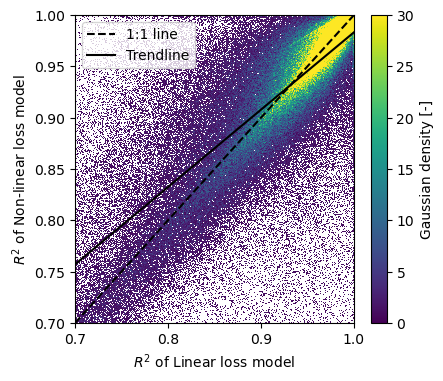

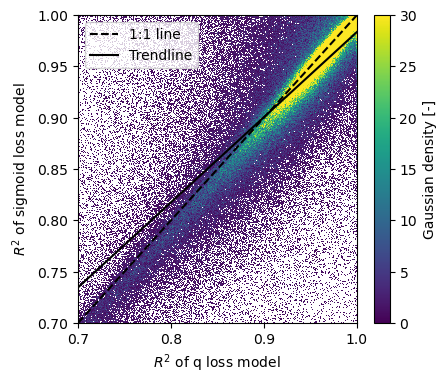

In [11]:
############################################################################
# PLOTTING FUNCTION STARTS HERE
###########################################################################


############################################################################
# Model performance comparison
###########################################################################
def using_datashader(ax, x, y, cmap):
    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        norm="linear",
        aspect="auto",
        vmin=0,
        vmax=30,
        ax=ax,
        cmap=cmap,
    )
    plt.colorbar(dsartist, label=f"Gaussian density [-]")


def plot_R2_models(df, R2_threshold, cmap):
    # Read data
    x = df["exp_r_squared"].values
    y = df["sigmoid_r_squared"].values

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(4.5, 4))
    # Calculate the point density
    sc = using_datashader(ax, x, y, cmap)

    # plt.title(rf'')
    plt.xlabel(r"$R^2$ of Linear loss model")
    plt.ylabel(r"$R^2$ of Non-linear loss model")

    # Add 1:1 line
    ax.plot(
        [R2_threshold, 1],
        [R2_threshold, 1],
        color="k",
        linestyle="--",
        label="1:1 line",
    )

    # Add a trendline
    coefficients = np.polyfit(x, y, 1)
    trendline_x = np.array([R2_threshold, 1])
    trendline_y = coefficients[0] * trendline_x + coefficients[1]
    ax.plot(trendline_x, trendline_y, color="k", label="Trendline")

    ax.set_xlim([R2_threshold, 1])
    ax.set_ylim([R2_threshold, 1])
    plt.legend()


# plot_R2_models(df=df, R2_threshold=0.0)

# Plot R2 of q vs exp model, where where both q and exp model performed R2 > 0.7 and covered >30% of the SM range
plot_R2_models(
    df=df_filt_sgm_and_exp_2, R2_threshold=success_modelfit_thresh, cmap="viridis"
)


def plot_R2_models_both_nonlinear(df, R2_threshold, cmap):
    # Read data
    x = df["q_r_squared"].values
    y = df["sigmoid_r_squared"].values

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(4.5, 4))
    # Calculate the point density
    sc = using_datashader(ax, x, y, cmap)

    # plt.title(rf'')
    plt.xlabel(r"$R^2$ of q loss model")
    plt.ylabel(r"$R^2$ of sigmoid loss model")

    # Add 1:1 line
    ax.plot(
        [R2_threshold, 1],
        [R2_threshold, 1],
        color="k",
        linestyle="--",
        label="1:1 line",
    )

    # Add a trendline
    coefficients = np.polyfit(x, y, 1)
    trendline_x = np.array([R2_threshold, 1])
    trendline_y = coefficients[0] * trendline_x + coefficients[1]
    ax.plot(trendline_x, trendline_y, color="k", label="Trendline")

    ax.set_xlim([R2_threshold, 1])
    ax.set_ylim([R2_threshold, 1])
    plt.legend()


# plot_R2_models(df=df, R2_threshold=0.0)

# Plot R2 of q vs exp model, where where both q and exp model performed R2 > 0.7 and covered >30% of the SM range
plot_R2_models_both_nonlinear(
    df=df_filt_sgm_and_q_2, R2_threshold=success_modelfit_thresh, cmap="viridis"
)

In [12]:
############################################################################
# Map plots
###########################################################################
def plot_map(df, coord_info, cmap, norm, var_item):
    # Get the mean values of the variable
    stat = df.groupby(["EASE_row_index", "EASE_column_index"])[
        var_item["column_name"]
    ].mean()

    # Reindex to the full EASE row/index extent
    new_index = pd.MultiIndex.from_tuples(
        zip(coord_info["EASE_row_index"], coord_info["EASE_column_index"]),
        names=["EASE_row_index", "EASE_column_index"],
    )
    stat_pad = stat.reindex(new_index, fill_value=np.nan)

    # Join latitude and longitude
    merged_data = (
        stat_pad.reset_index()
        .merge(
            coord_info[
                ["EASE_row_index", "EASE_column_index", "latitude", "longitude"]
            ],
            on=["EASE_row_index", "EASE_column_index"],
            how="left",
        )
        .set_index(["EASE_row_index", "EASE_column_index"])
    )

    # Create pivot array
    pivot_array = merged_data.pivot(
        index="latitude", columns="longitude", values=var_item["column_name"]
    )
    pivot_array[pivot_array.index > -60]  # Exclude antarctica in the map (no data)

    # Get lat and lon
    lons = pivot_array.columns.values
    lats = pivot_array.index.values

    # Plot in the map
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": ccrs.Robinson()})
    im = ax.pcolormesh(
        lons, lats, pivot_array, norm=norm, cmap=cmap, transform=ccrs.PlateCarree()
    )
    ax.set_extent([-160, 170, -60, 90], crs=ccrs.PlateCarree())
    ax.coastlines()

    # Add colorbar
    cbar = plt.colorbar(
        im,
        ax=ax,
        orientation="vertical",
        label=f'Median {var_item["label"]}',
        shrink=0.35,
        pad=0.02,
    )

    # Set plot title and labels
    # ax.set_title(f'Mean {variable_name} per pixel')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

In [13]:
var_key = "sigmoid_ETmax_denormalized"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

KeyError: 'sigmoid_ETmax_denormalized'

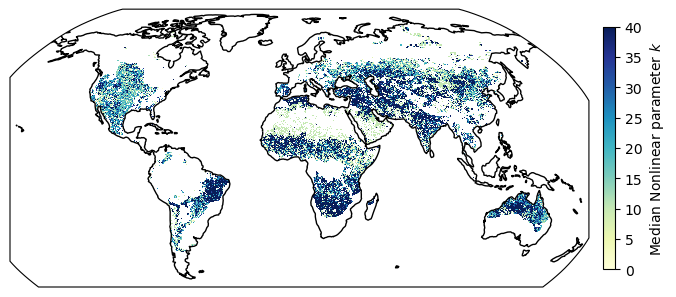

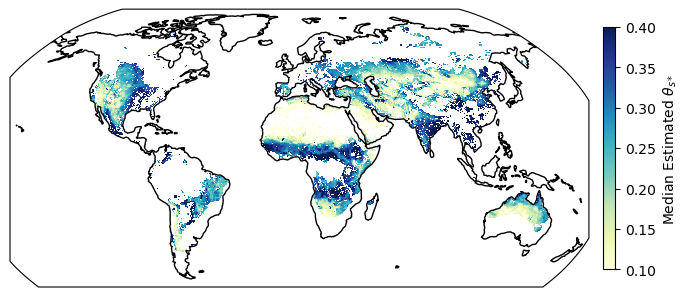

In [14]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [15]:
# Difference between R2 values of two models
df = df.assign(diff_R2=df["sigmoid_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from sigmoid model
df["sigmoid_ETmax_denormalized"] = (
    df["sigmoid_ETmax"] * (df["max_sm"] - df["min_sm"]) * z_mm
)

# Get the binned dataset

# sand bins
df["sand_bins"] = pd.cut(df["sand_fraction"], bins=sand_bin_list, include_lowest=True)
first_I = df["sand_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["sand_bins"] = df["sand_bins"].cat.rename_categories({first_I: new_I})

# ai_bins
df["ai_bins"] = pd.cut(df["AI"], bins=ai_bin_list, include_lowest=True)
first_I = df["ai_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["ai_bins"] = df["ai_bins"].cat.rename_categories({first_I: new_I})

In [16]:
# Difference between R2 values of two models
df = df.assign(diff_R2=df["sigmoid_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from sigmoid model
df["sigmoid_ETmax_denormalized"] = (
    df["sigmoid_ETmax"] * (df["max_sm"] - df["min_sm"]) * z_mm
)

# Get the binned dataset

# sand bins
df["sand_bins"] = pd.cut(df["sand_fraction"], bins=sand_bin_list, include_lowest=True)
first_I = df["sand_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["sand_bins"] = df["sand_bins"].cat.rename_categories({first_I: new_I})

# ai_bins
df["ai_bins"] = pd.cut(df["AI"], bins=ai_bin_list, include_lowest=True)
first_I = df["ai_bins"].cat.categories[0]
new_I = pd.Interval(0, first_I.right)
df["ai_bins"] = df["ai_bins"].cat.rename_categories({first_I: new_I})

In [17]:
# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)

In [18]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.6],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s50": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

In [19]:
# Runs where sigmoid model performed good
df_filt_sgm = df[df["sigmoid_r_squared"] >= success_modelfit_thresh].copy()
df_filt_sgm_2 = df_filt_sgm[df_filt_sgm["sm_range"] > sm_range_thresh].copy()
print(f"sigmoid model fit was successful: {len(df_filt_sgm)}")
print(
    f"sigmoid model fit was successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_2)}"
)

# Runs where exponential model performed good
df_filt_exp = df[df["exp_r_squared"] >= success_modelfit_thresh].copy()
df_filt_exp_2 = df_filt_exp[df_filt_exp["sm_range"] > sm_range_thresh].copy()
print(f"exp model fit was successful: {len(df_filt_exp)}")
print(
    f"exp model fit was successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_exp_2)}"
)

# Runs where both q and sigmoid model performed good
df_filt_sgm_and_q = df[
    (df["sigmoid_r_squared"] >= success_modelfit_thresh)
    & (df["q_r_squared"] >= success_modelfit_thresh)
].copy()
df_filt_sgm_and_q_2 = df_filt_sgm_and_q[
    df_filt_sgm_and_q["sm_range"] > sm_range_thresh
].copy()
print(f"both sigmoid and q model fit was successful: {len(df_filt_sgm_and_q)}")
print(
    f"both sigmoid and q model fit was successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_and_q)}"
)

# Runs where either of the model performed satisfactory
df_filt_sgm_or_exp = df[
    (df["sigmoid_r_squared"] >= success_modelfit_thresh)
    | (df["exp_r_squared"] >= success_modelfit_thresh)
].copy()
df_filt_sgm_or_exp_2 = df_filt_sgm_or_exp[
    df_filt_sgm_or_exp["sm_range"] > sm_range_thresh
].copy()
print(f"either q or exp model fit was successful: {len(df_filt_sgm_or_exp)}")
print(
    f"either q or exp model were successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_or_exp_2)}"
)

# Runs where both of the model performed satisfactory
df_filt_sgm_and_exp = df[
    (df["sigmoid_r_squared"] >= success_modelfit_thresh)
    & (df["exp_r_squared"] >= success_modelfit_thresh)
].copy()
df_filt_sgm_and_exp_2 = df_filt_sgm_and_exp[
    df_filt_sgm_and_exp["sm_range"] > sm_range_thresh
].copy()
print(f"both q and exp model fit was successful: {len(df_filt_sgm_and_exp)}")
print(
    f"both q and exp model were successful & fit over {sm_range_thresh*100} percent of the soil mositure range: {len(df_filt_sgm_and_exp_2)}"
)

sigmoid model fit was successful: 377539
sigmoid model fit was successful & fit over 30.0 percent of the soil mositure range: 314775
exp model fit was successful: 386175
exp model fit was successful & fit over 30.0 percent of the soil mositure range: 314674
both sigmoid and q model fit was successful: 366282
both sigmoid and q model fit was successful & fit over 30.0 percent of the soil mositure range: 366282
either q or exp model fit was successful: 402585
either q or exp model were successful & fit over 30.0 percent of the soil mositure range: 327445
both q and exp model fit was successful: 361129
both q and exp model were successful & fit over 30.0 percent of the soil mositure range: 302004


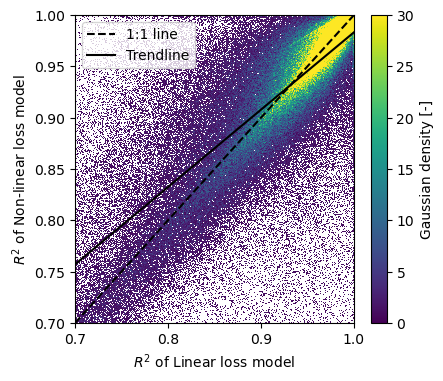

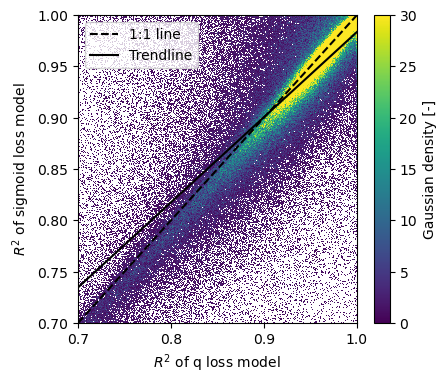

In [20]:
############################################################################
# PLOTTING FUNCTION STARTS HERE
###########################################################################


############################################################################
# Model performance comparison
###########################################################################
def using_datashader(ax, x, y, cmap):
    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        norm="linear",
        aspect="auto",
        vmin=0,
        vmax=30,
        ax=ax,
        cmap=cmap,
    )
    plt.colorbar(dsartist, label=f"Gaussian density [-]")


def plot_R2_models(df, R2_threshold, cmap):
    # Read data
    x = df["exp_r_squared"].values
    y = df["sigmoid_r_squared"].values

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(4.5, 4))
    # Calculate the point density
    sc = using_datashader(ax, x, y, cmap)

    # plt.title(rf'')
    plt.xlabel(r"$R^2$ of Linear loss model")
    plt.ylabel(r"$R^2$ of Non-linear loss model")

    # Add 1:1 line
    ax.plot(
        [R2_threshold, 1],
        [R2_threshold, 1],
        color="k",
        linestyle="--",
        label="1:1 line",
    )

    # Add a trendline
    coefficients = np.polyfit(x, y, 1)
    trendline_x = np.array([R2_threshold, 1])
    trendline_y = coefficients[0] * trendline_x + coefficients[1]
    ax.plot(trendline_x, trendline_y, color="k", label="Trendline")

    ax.set_xlim([R2_threshold, 1])
    ax.set_ylim([R2_threshold, 1])
    plt.legend()


# plot_R2_models(df=df, R2_threshold=0.0)

# Plot R2 of q vs exp model, where where both q and exp model performed R2 > 0.7 and covered >30% of the SM range
plot_R2_models(
    df=df_filt_sgm_and_exp_2, R2_threshold=success_modelfit_thresh, cmap="viridis"
)


def plot_R2_models_both_nonlinear(df, R2_threshold, cmap):
    # Read data
    x = df["q_r_squared"].values
    y = df["sigmoid_r_squared"].values

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(4.5, 4))
    # Calculate the point density
    sc = using_datashader(ax, x, y, cmap)

    # plt.title(rf'')
    plt.xlabel(r"$R^2$ of q loss model")
    plt.ylabel(r"$R^2$ of sigmoid loss model")

    # Add 1:1 line
    ax.plot(
        [R2_threshold, 1],
        [R2_threshold, 1],
        color="k",
        linestyle="--",
        label="1:1 line",
    )

    # Add a trendline
    coefficients = np.polyfit(x, y, 1)
    trendline_x = np.array([R2_threshold, 1])
    trendline_y = coefficients[0] * trendline_x + coefficients[1]
    ax.plot(trendline_x, trendline_y, color="k", label="Trendline")

    ax.set_xlim([R2_threshold, 1])
    ax.set_ylim([R2_threshold, 1])
    plt.legend()


# plot_R2_models(df=df, R2_threshold=0.0)

# Plot R2 of q vs exp model, where where both q and exp model performed R2 > 0.7 and covered >30% of the SM range
plot_R2_models_both_nonlinear(
    df=df_filt_sgm_and_q_2, R2_threshold=success_modelfit_thresh, cmap="viridis"
)

In [21]:
############################################################################
# Map plots
###########################################################################
def plot_map(df, coord_info, cmap, norm, var_item):
    # Get the mean values of the variable
    stat = df.groupby(["EASE_row_index", "EASE_column_index"])[
        var_item["column_name"]
    ].mean()

    # Reindex to the full EASE row/index extent
    new_index = pd.MultiIndex.from_tuples(
        zip(coord_info["EASE_row_index"], coord_info["EASE_column_index"]),
        names=["EASE_row_index", "EASE_column_index"],
    )
    stat_pad = stat.reindex(new_index, fill_value=np.nan)

    # Join latitude and longitude
    merged_data = (
        stat_pad.reset_index()
        .merge(
            coord_info[
                ["EASE_row_index", "EASE_column_index", "latitude", "longitude"]
            ],
            on=["EASE_row_index", "EASE_column_index"],
            how="left",
        )
        .set_index(["EASE_row_index", "EASE_column_index"])
    )

    # Create pivot array
    pivot_array = merged_data.pivot(
        index="latitude", columns="longitude", values=var_item["column_name"]
    )
    pivot_array[pivot_array.index > -60]  # Exclude antarctica in the map (no data)

    # Get lat and lon
    lons = pivot_array.columns.values
    lats = pivot_array.index.values

    # Plot in the map
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": ccrs.Robinson()})
    im = ax.pcolormesh(
        lons, lats, pivot_array, norm=norm, cmap=cmap, transform=ccrs.PlateCarree()
    )
    ax.set_extent([-160, 170, -60, 90], crs=ccrs.PlateCarree())
    ax.coastlines()

    # Add colorbar
    cbar = plt.colorbar(
        im,
        ax=ax,
        orientation="vertical",
        label=f'Median {var_item["label"]}',
        shrink=0.35,
        pad=0.02,
    )

    # Set plot title and labels
    # ax.set_title(f'Mean {variable_name} per pixel')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

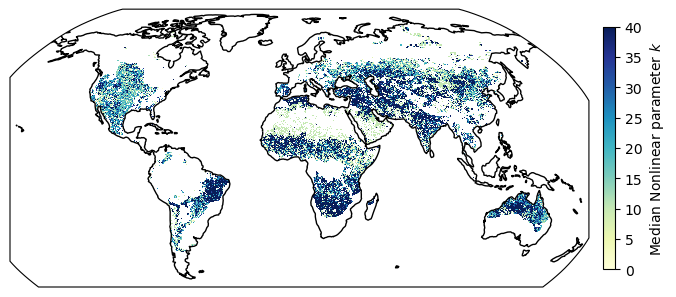

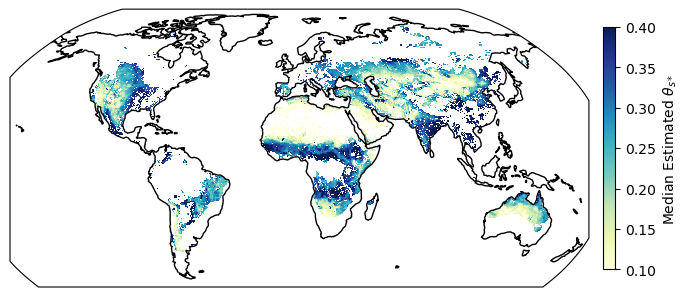

In [22]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [23]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.6],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

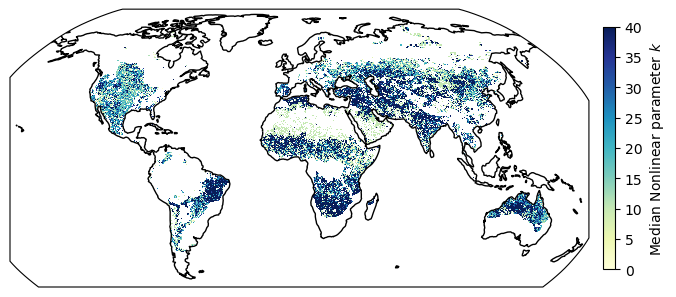

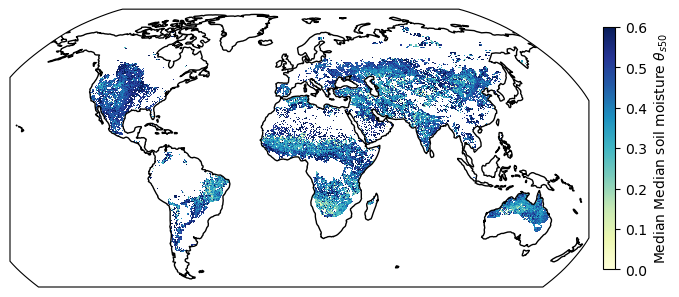

In [24]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [25]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.4],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

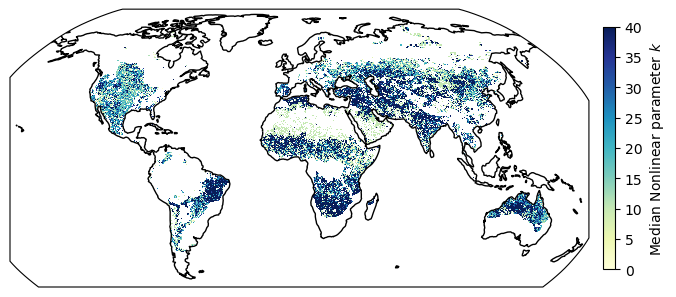

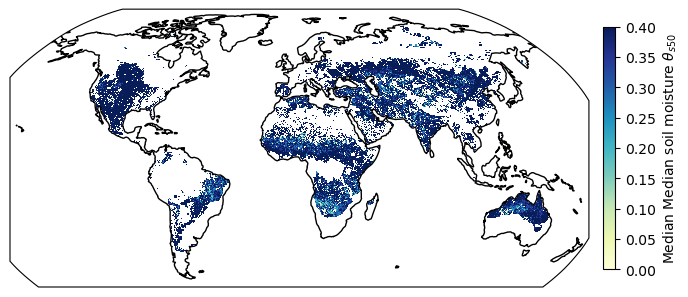

In [26]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [27]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 1.0],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

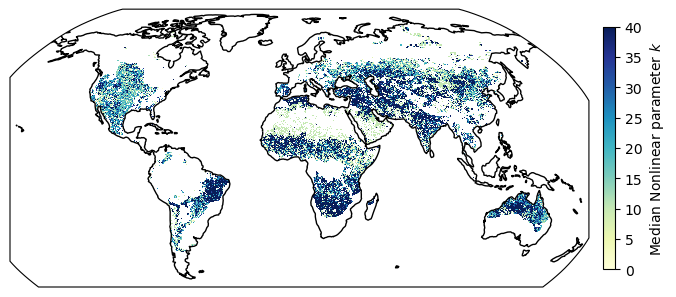

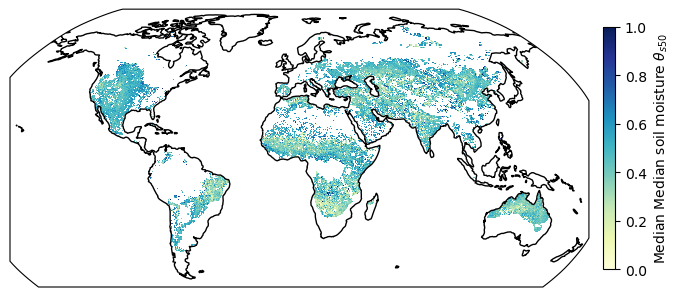

In [28]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [29]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.5],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

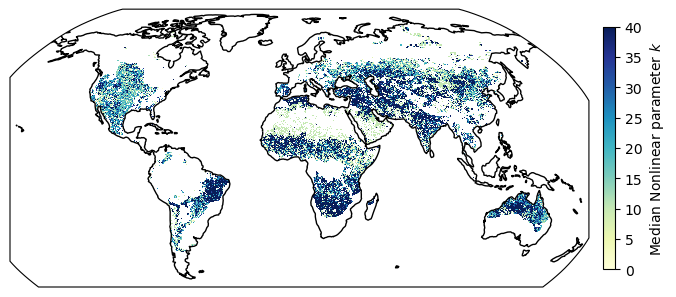

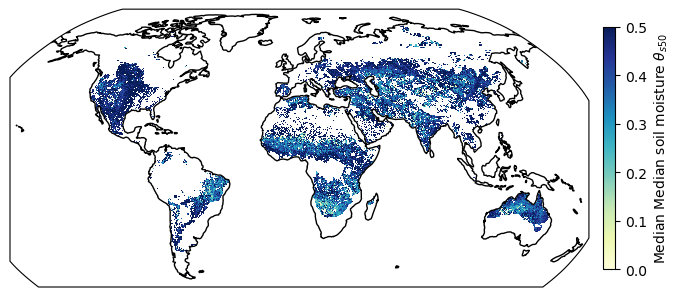

In [30]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [31]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.4],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

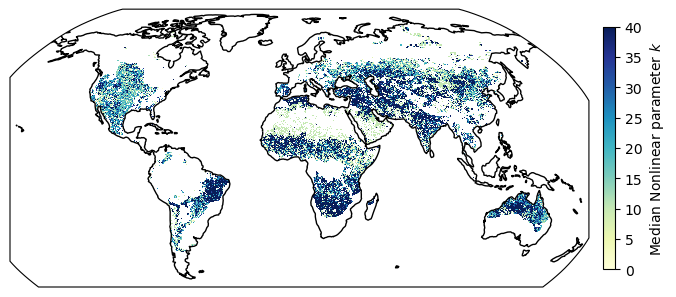

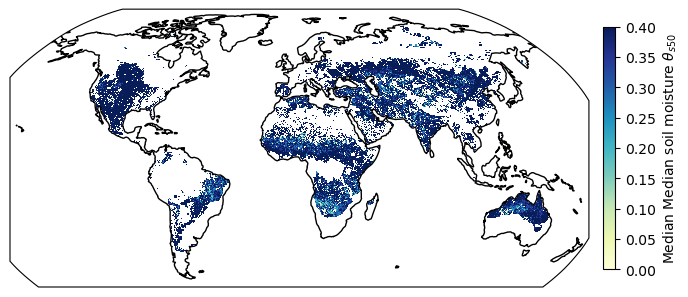

In [32]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [33]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.8],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10],
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

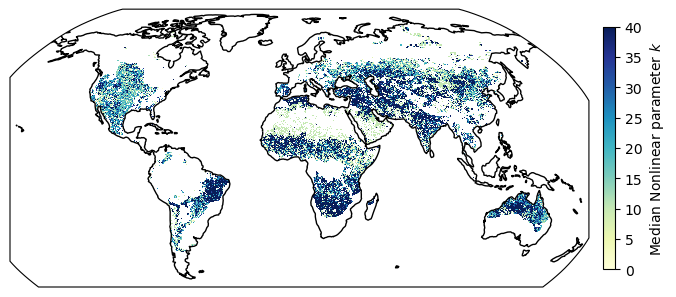

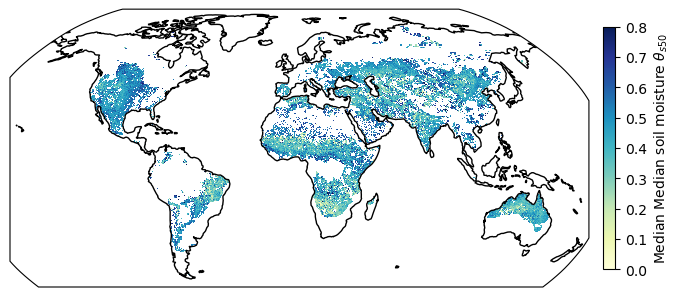

In [34]:
var_key = "sigmoid_k"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

var_key = "sigmoid_s50"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_2,
    coord_info=coord_info,
    cmap="YlGnBu",
    norm=norm,
    var_item=var_dict[var_key],
)

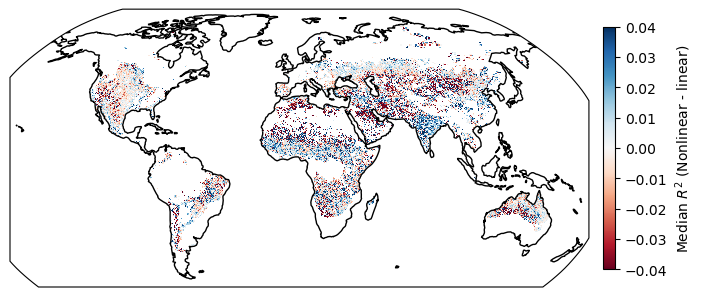

In [35]:
# Plot the map of R2 differences, where both q and exp model performed > 0.7 and covered >30% of the SM range
var_key = "diff_R2"
norm = Normalize(vmin=var_dict[var_key]["lim"][0], vmax=var_dict[var_key]["lim"][1])
plot_map(
    df=df_filt_sgm_and_exp_2,
    coord_info=coord_info,
    cmap="RdBu",
    norm=norm,
    var_item=var_dict[var_key],
)

In [36]:
############################################################################
# Box plots (might go supplemental)
###########################################################################


def plot_boxplots(df, x_var, y_var):
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(
        x=x_var["column_name"],
        y=y_var["column_name"],
        data=df,
        boxprops=dict(facecolor="lightgray"),
    )
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel(f'{x_var["label"]} {x_var["unit"]}')
    ax.set_ylabel(f'{y_var["label"]} {y_var["unit"]}')
    ax.set_ylim(y_var["lim"][0], y_var["lim"][1] * 5)
    plt.tight_layout()

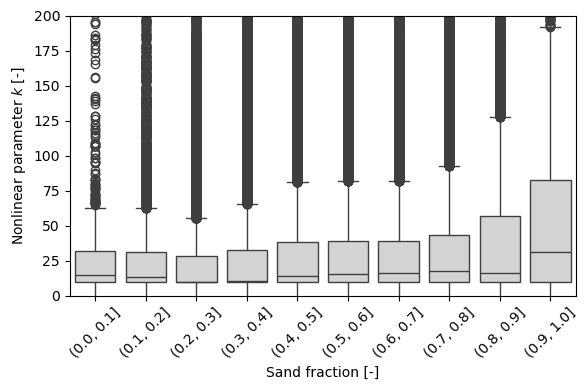

In [37]:
plot_boxplots(df_filt_sgm_2, var_dict["sand_bins"], var_dict["sigmoid_k"])

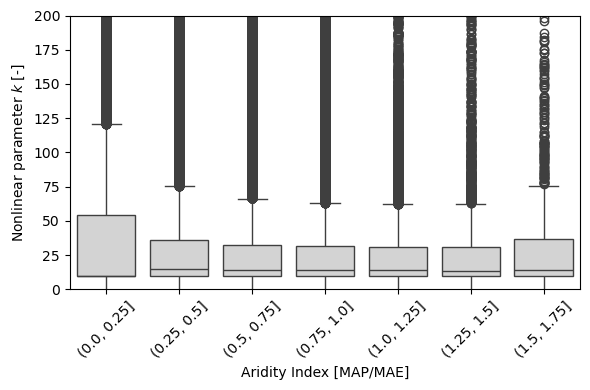

In [38]:
plot_boxplots(df_filt_sgm_2, var_dict["ai_bins"], var_dict["sigmoid_k"])

In [39]:
def wrap_at_space(text, max_width):
    parts = text.split(" ")
    wrapped_parts = [wrap(part, max_width) for part in parts]
    return "\n".join([" ".join(wrapped_part) for wrapped_part in wrapped_parts])


def plot_boxplots_categorical(df, x_var, y_var, categories, colors):
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot the boxplot with specified colors and increased alpha
    sns.boxplot(
        x=x_var["column_name"],
        y=y_var["column_name"],
        data=df,
        # hue=x_var['column_name'],
        legend=False,
        order=categories,
        palette=colors,
        ax=ax,
    )

    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor(mcolors.to_rgba((r, g, b), alpha=0.5))

    # Optionally, adjust layout
    plt.tight_layout()
    ax.set_xlabel(f'{x_var["label"]}')
    max_label_width = 20
    ax.set_xticklabels(
        [
            wrap_at_space(label.get_text(), max_label_width)
            for label in ax.get_xticklabels()
        ]
    )
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel(f'{y_var["label"]} {y_var["unit"]}')
    # Show the plot
    ax.set_ylim(y_var["lim"][0], y_var["lim"][1])
    plt.tight_layout()
    plt.show()

<ipython-input-39-45425313ebd6>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-39-45425313ebd6>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


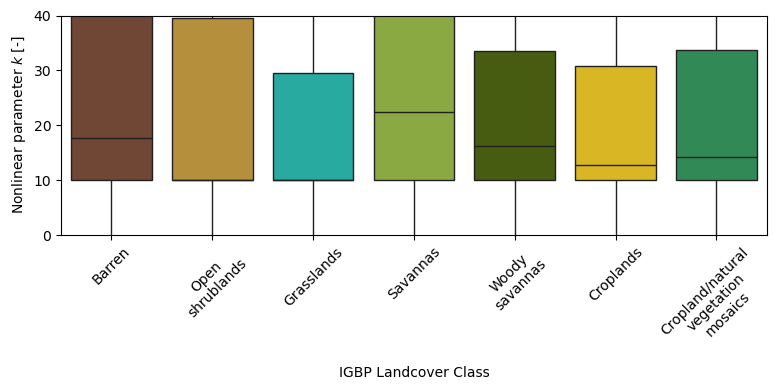

<ipython-input-39-45425313ebd6>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-39-45425313ebd6>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


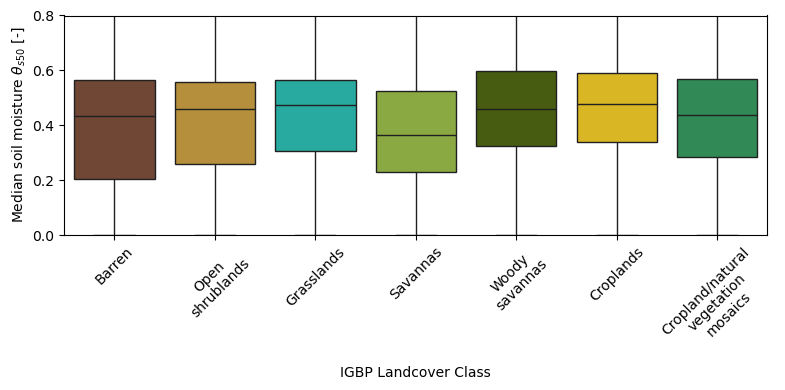

In [40]:
plot_boxplots_categorical(
    df_filt_sgm_2,
    var_dict["veg_class"],
    var_dict["sigmoid_k"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
)

plot_boxplots_categorical(
    df_filt_sgm_2,
    var_dict["veg_class"],
    var_dict["sigmoid_s50"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
)

<ipython-input-41-337a780fa60a>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


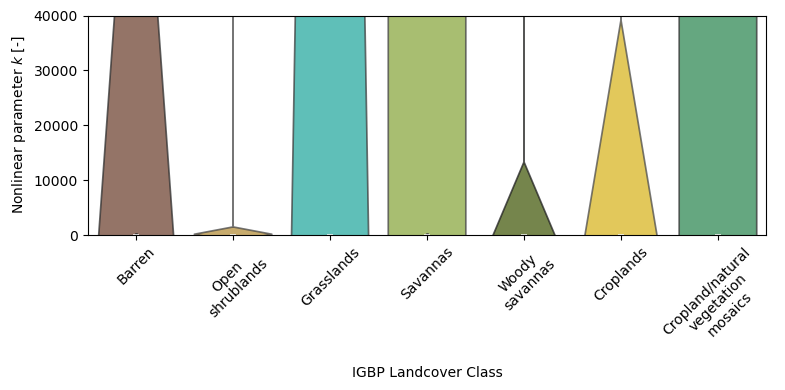

In [41]:
def plot_violin_categorical(df, x_var, y_var, categories, colors):
    fig, ax = plt.subplots(figsize=(8, 4))
    for i, category in enumerate(categories):
        subset = df[df[x_var["column_name"]] == category]
        sns.violinplot(
            x=x_var["column_name"],
            y=y_var["column_name"],
            data=subset,
            order=[category],
            color=colors[i],
            ax=ax,
            alpha=0.75,
            cut=0,
        )

    # ax = sns.violinplot(x='abbreviation', y='sigmoid_k', data=filtered_df, order=vegetation_orders, palette=palette_dict) # boxprops=dict(facecolor='lightgray'),
    ax.set_xlabel(f'{x_var["label"]}')
    max_label_width = 20
    ax.set_xticklabels(
        [
            wrap_at_space(label.get_text(), max_label_width)
            for label in ax.get_xticklabels()
        ]
    )
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel(f'{y_var["label"]} {y_var["unit"]}')
    # Show the plot
    ax.set_ylim(y_var["lim"][0], y_var["lim"][1] * 1000)
    plt.tight_layout()
    plt.show()


plot_violin_categorical(
    df_filt_sgm_2,
    var_dict["veg_class"],
    var_dict["sigmoid_k"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
)

In [42]:
############################################################################
# Loss function plots
###########################################################################


def plot_loss_func(df, z_var, cmap):
    fig, ax = plt.subplots(figsize=(4, 4))

    # Get unique bins
    bins_in_range = df[z_var["column_name"]].unique()
    bins_list = [bin for bin in bins_in_range if pd.notna(bin)]
    bin_sorted = sorted(bins_list, key=lambda x: x.left)

    # For each row in the subset, calculate the loss for a range of theta values
    for i, category in enumerate(bin_sorted):
        subset = df[df[z_var["column_name"]] == category]

        # Get the median of all the related loss function parameters
        theta_min = subset["min_sm"].median()
        theta_max = subset["max_sm"].median()
        k = subset["sigmoid_k"].median()
        s50 = subset["sigmoid_s50"].median()
        ETmax = subset["sigmoid_ETmax"].median()

        # Calculate the loss function
        theta = np.arange(theta_min, theta_max, 0.01)
        dtheta = loss_sigmoid2(theta, s50, k, ETmax)

        # Plot median line
        ax.plot(
            theta,
            dtheta,
            label=f"{category}",
            color=plt.get_cmap(cmap)(i / len(bins_list)),
        )

    ax.invert_yaxis()
    ax.set_xlabel(f"{var_dict['theta']['label']} {var_dict['theta']['unit']}")
    ax.set_ylabel(f"{var_dict['dtheta']['label']} {var_dict['dtheta']['unit']}")
    ax.set_title(f'Median loss function by {z_var["label"]} {z_var["unit"]}')
    # ax.set_xlim(var_dict['theta']['lim'][0],var_dict['theta']['lim'][1])
    # ax.set_ylim(var_dict['dtheta']['lim'][1],var_dict['dtheta']['lim'][0])

    # Adjust the layout so the subplots fit into the figure area
    plt.tight_layout()
    # Add a legend
    plt.legend(bbox_to_anchor=(1, 1))
    # Show the plot
    plt.show()

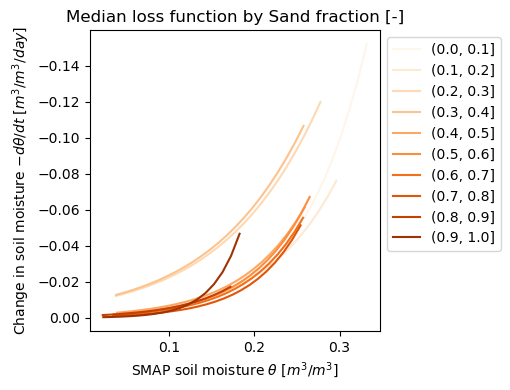

<ipython-input-43-c7eec051e727>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filt_sgm_and_exp_2[["id_x", "sand_bins"]].groupby("sand_bins").count()


id_x
sand_bins        
(0.0, 0.1]   1094
(0.1, 0.2]  11168
(0.2, 0.3]  41584
(0.3, 0.4]  60837
(0.4, 0.5]  67208
(0.5, 0.6]  45083
(0.6, 0.7]  30246
(0.7, 0.8]  23030
(0.8, 0.9]  17480
(0.9, 1.0]   4261

In [43]:
plot_loss_func(df_filt_sgm_2, var_dict["sand_bins"], sand_cmap)
df_filt_sgm_and_exp_2[["id_x", "sand_bins"]].groupby("sand_bins").count()

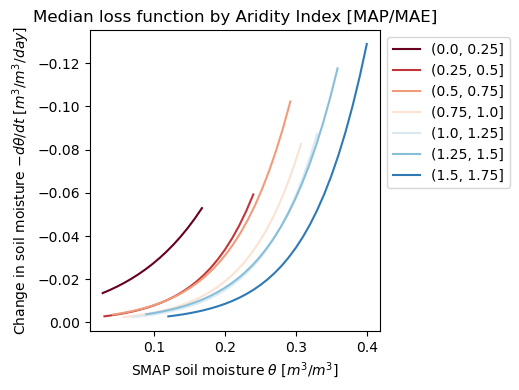

<ipython-input-44-616d65b1ba71>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filt_sgm_and_exp_2[["id_x", "ai_bins"]].groupby("ai_bins").count()


id_x
ai_bins            
(0.0, 0.25]   64107
(0.25, 0.5]  100108
(0.5, 0.75]   66362
(0.75, 1.0]   43781
(1.0, 1.25]   19438
(1.25, 1.5]    5447
(1.5, 1.75]    1674

In [44]:
plot_loss_func(df_filt_sgm_2, var_dict["ai_bins"], ai_cmap)
df_filt_sgm_and_exp_2[["id_x", "ai_bins"]].groupby("ai_bins").count()

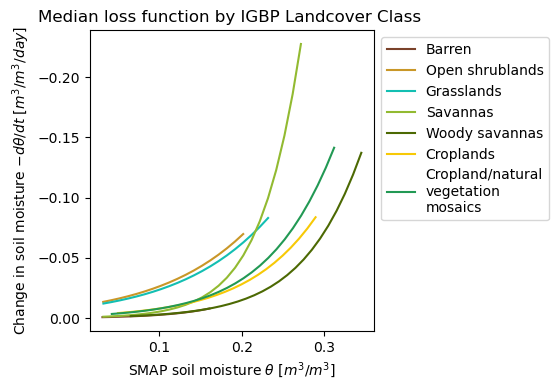

In [45]:
def wrap_text(text, width):
    return "\n".join(wrap(text, width))


def plot_loss_func_categorical(df, z_var, categories, colors):
    fig, ax = plt.subplots(figsize=(4, 4))

    # For each row in the subset, calculate the loss for a range of theta values
    for i, category in enumerate(categories):
        subset = df[df[z_var["column_name"]] == category]

        theta_min = subset["min_sm"].median()
        theta_max = subset["max_sm"].median()
        k = subset["sigmoid_k"].median()
        s50 = subset["sigmoid_s50"].median()
        ETmax = subset["sigmoid_ETmax"].median()

        # Calculate the loss function
        theta = np.arange(theta_min, theta_max, 0.01)
        dtheta = loss_sigmoid2(theta, s50, k, ETmax)

        # Plot median line
        ax.plot(theta, dtheta, label=category, color=colors[i])

    ax.invert_yaxis()
    ax.set_xlabel(f"{var_dict['theta']['label']} {var_dict['theta']['unit']}")
    ax.set_ylabel(f"{var_dict['dtheta']['label']} {var_dict['dtheta']['unit']}")
    ax.set_title(f'Median loss function by {z_var["label"]} {z_var["unit"]}')

    # Adjust the layout so the subplots fit into the figure area
    plt.tight_layout()
    # Add a legend
    plt.legend(bbox_to_anchor=(1, 1))
    legend = plt.legend(bbox_to_anchor=(1, 1))
    for text in legend.get_texts():
        label = text.get_text()
        wrapped_label = wrap_text(label, 16)  # Wrap text after 16 characters
        text.set_text(wrapped_label)
    # Show the plot
    plt.show()


plot_loss_func_categorical(
    df_filt_sgm_2,
    var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
)

In [46]:
count_veg_samples = df[df.name.isin(vegetation_color_dict.keys())]
count_veg_samples[["id_x", "name"]].groupby("name").count()

id_x
name                                       
Barren                                75716
Cropland/natural vegetation mosaics   40500
Croplands                            102197
Grasslands                           137323
Open shrublands                       74606
Savannas                              86213
Woody savannas                        70382

In [47]:
############################################################################
# Scatter plots with error bars
###########################################################################


def plot_scatter_with_errorbar(
    df, x_var, y_var, z_var, categories, colors, quantile, plot_logscale
):
    fig, ax = plt.subplots(figsize=(5, 5))
    stats_dict = {}

    # Calculate median and 90% confidence intervals for each vegetation class
    for i, category in enumerate(categories):
        subset = df[df[z_var["column_name"]] == category]

        # Median calculation
        x_median = subset[x_var["column_name"]].median()
        y_median = subset[y_var["column_name"]].median()

        # 90% CI calculation, using the 5th and 95th percentiles
        x_ci_low, x_ci_high = np.percentile(
            subset[x_var["column_name"]], [quantile, 100 - quantile]
        )
        y_ci_low, y_ci_high = np.percentile(
            subset[y_var["column_name"]], [quantile, 100 - quantile]
        )

        # Store in dict
        stats_dict[category] = {
            "x_median": x_median,
            "y_median": y_median,
            "x_ci": (x_median - x_ci_low, x_ci_high - x_median),
            "y_ci": (y_median - y_ci_low, y_ci_high - y_median),
            "color": colors[i],
        }

    # Now plot medians with CIs
    for category, stats in stats_dict.items():
        plt.errorbar(
            stats["x_median"],
            stats["y_median"],
            xerr=np.array([[stats["x_ci"][0]], [stats["x_ci"][1]]]),
            yerr=np.array([[stats["y_ci"][0]], [stats["y_ci"][1]]]),
            fmt="o",
            label=category,
            capsize=5,
            capthick=2,
            color=stats["color"],
            alpha=0.7,
            markersize=10,
            mec="darkgray",
            mew=1,
        )

    # Add labels and title
    ax.set_xlabel(f"{x_var['label']} {x_var['unit']}")
    ax.set_ylabel(f"{y_var['label']} {y_var['unit']}")
    plt.title(f"Median scatter plot with {quantile}% confidence interval")

    # Add a legend
    plt.legend(bbox_to_anchor=(1, 1))
    if plot_logscale:
        plt.xscale("log")
    ax.set_xlim(x_var["lim"][0], x_var["lim"][1])
    ax.set_ylim(y_var["lim"][0], y_var["lim"][1])

    # Show the plot
    plt.show()

<ipython-input-47-788b60667178>:65: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_var["lim"][0], x_var["lim"][1])


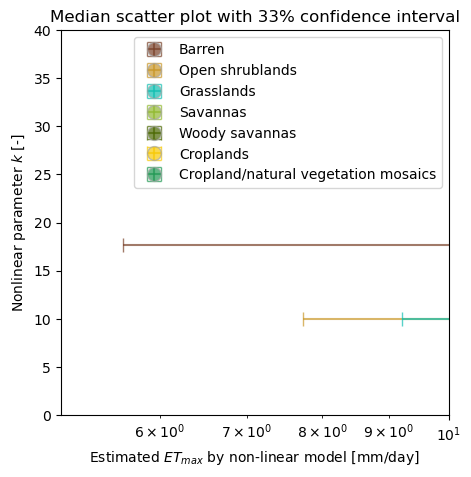

In [48]:
plot_scatter_with_errorbar(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_ETmax"],
    y_var=var_dict["sigmoid_k"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
    quantile=33,
    plot_logscale=True,
)

In [49]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.8],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 10]0,
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-49-ebf0d2a016ca>, line 67)

In [50]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2023-11-28_global_sigmoid_95asmax"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
success_modelfit_thresh = 0.7
sm_range_thresh = 0.3
z_mm = 50  # Soil thickness

# cmap for sand
sand_bin_list = [i * 0.1 for i in range(11)]
sand_cmap = "Oranges"

# cmap for ai
ai_bin_list = [i * 0.25 for i in range(8)]
ai_cmap = "RdBu"

# Define the specific order for vegetation categories.
vegetation_color_dict = {
    "Barren": "#7A422A",
    "Open shrublands": "#C99728",
    "Grasslands": "#13BFB2",
    "Savannas": "#92BA31",
    "Woody savannas": "#4C6903",
    "Croplands": "#F7C906",
    "Cropland/natural vegetation mosaics": "#229954",
}

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture $\theta$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture $-d\theta/dt$",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
    "sigmoid_k": {
        "column_name": "sigmoid_k",
        "symbol": r"$k$",
        "label": r"Nonlinear parameter $k$",
        "unit": "[-]",
        "lim": [0, 40],
    },
    "sigmoid_s50": {
        "column_name": "sigmoid_s50",
        "symbol": r"$\theta_{s50}$",
        "label": r"Median soil moisture $\theta_{s50}$",
        "unit": "[-]",
        "lim": [0, 0.8],
    },
    "sigmoid_ETmax": {
        "column_name": "sigmoid_ETmax_denormalized",
        "symbol": r"$ET_{max}$",
        "label": r"Estimated $ET_{max}$ by non-linear model",
        "unit": "[mm/day]",
        "lim": [0, 100],
    },
    "sigmoid_s_star": {
        "column_name": "max_sm",
        "symbol": r"$\theta_{s*}$",
        "label": r"Estimated $\theta_{s*}$",
        "unit": r"$[m^3/m^3]$",
        "lim": [0.1, 0.4],
    },
    "sand_bins": {
        "column_name": "sand_bins",
        "symbol": r"",
        "label": r"Sand fraction",
        "unit": "[-]",
        "lim": [0.0, 1.0],
    },
    "ai_bins": {
        "column_name": "ai_bins",
        "symbol": r"AI",
        "label": r"Aridity Index",
        "unit": "[MAP/MAE]",
        "lim": [0.0, 2.0],
    },
    "veg_class": {
        "column_name": "name",
        "symbol": r"",
        "label": r"IGBP Landcover Class",
        "unit": "",
        "lim": [0, 1],
    },
    "diff_R2": {
        "column_name": "diff_R2",
        "symbol": r"$R^2$",
        "label": r"$R^2$ (Nonlinear - linear)",
        "unit": "[-]",
        "lim": [-0.04, 0.04],
    },
}
############################################################################

<ipython-input-47-788b60667178>:65: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_var["lim"][0], x_var["lim"][1])


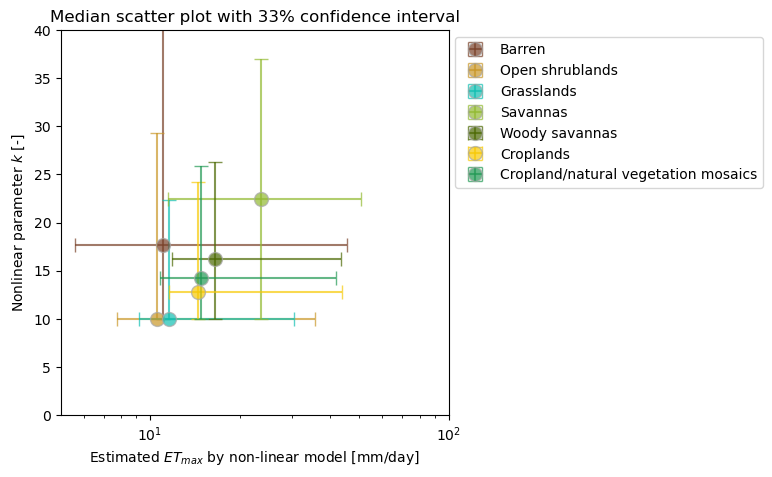

In [51]:
plot_scatter_with_errorbar(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_ETmax"],
    y_var=var_dict["sigmoid_k"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
    quantile=33,
    plot_logscale=True,
)

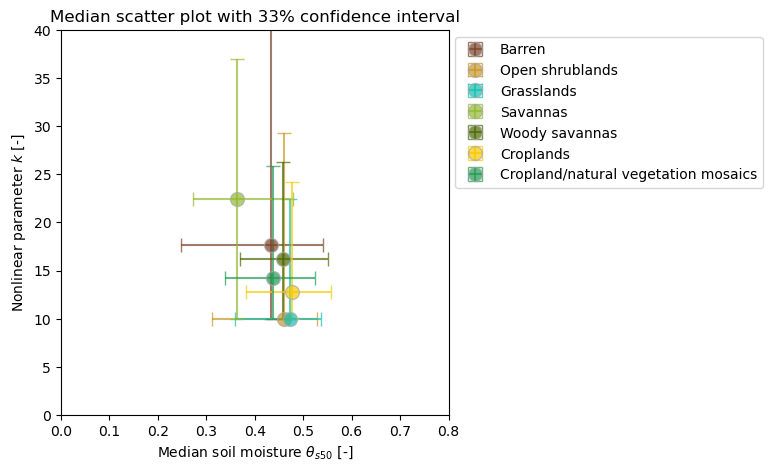

In [52]:
plot_scatter_with_errorbar(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_s50"],
    y_var=var_dict["sigmoid_k"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
    quantile=33,
    plot_logscale=False,
)

<ipython-input-47-788b60667178>:65: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_var["lim"][0], x_var["lim"][1])


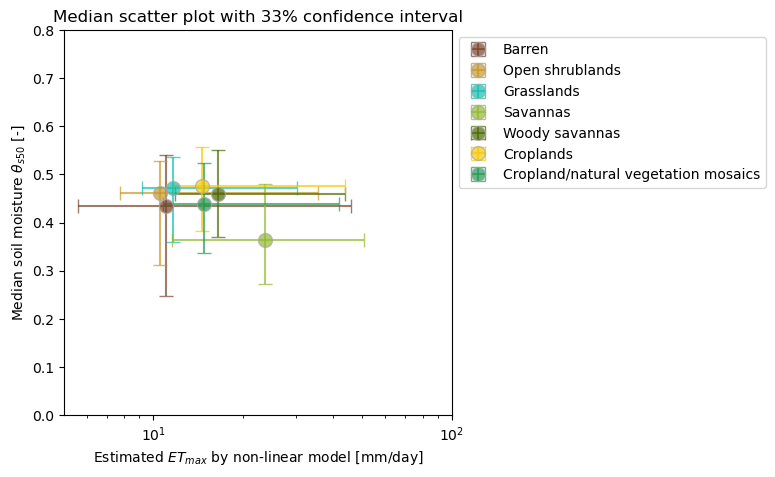

In [53]:
plot_scatter_with_errorbar(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_ETmax"],
    y_var=var_dict["sigmoid_s50"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
    quantile=33,
    plot_logscale=True,
)

In [54]:
def plot_2d_density(
    df, x_var, y_var, z_var, categories, colors, quantile, plot_logscale
):
    fig, ax = plt.subplots(figsize=(5, 5))
    kde_objects = []

    # Calculate and plot density for each category
    for i, category in enumerate(categories):
        subset = df[df[z_var["column_name"]] == category]
        x_data = subset[x_var["column_name"]]
        y_data = subset[y_var["column_name"]]

        # Calculate KDE
        kde = gaussian_kde([x_data, y_data])
        xmin, xmax = x_var["lim"]
        ymin, ymax = y_var["lim"]
        xi, yi = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        zi = kde(np.vstack([xi.flatten(), yi.flatten()]))

        # Find contour levels to fill between for middle 30%
        levels = np.linspace(zi.min(), zi.max(), 100)
        middle_levels = np.quantile(levels, [quantile / 100, 1.0])

        # Plot KDE and fill relevant contours
        # ax.contour(xi, yi, zi.reshape(xi.shape), levels=10, colors="white")
        ax.contourf(
            xi,
            yi,
            zi.reshape(xi.shape),
            levels=middle_levels,
            colors=colors[i],
            alpha=0.5,
            label=category,
        )

    # Add labels and title
    ax.set_xlabel(f"{x_var['label']} {x_var['unit']}")
    ax.set_ylabel(f"{y_var['label']} {y_var['unit']}")
    plt.title(f"Density > {quantile} percentile")

    # Set axis scales and limits
    if plot_logscale:
        ax.set_xscale("log")
    ax.set_xlim(x_var["lim"][0], x_var["lim"][1])
    ax.set_ylim(y_var["lim"][0], y_var["lim"][1])
    plt.legend(bbox_to_anchor=(1, 1))
    legend = plt.legend(bbox_to_anchor=(1, 1))
    for text in legend.get_texts():
        label = text.get_text()
        wrapped_label = wrap_text(label, 16)  # Wrap text after 16 characters
        text.set_text(wrapped_label)
    # Show the plot
    plt.show()

<ipython-input-54-be1af6d9928c>:27: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


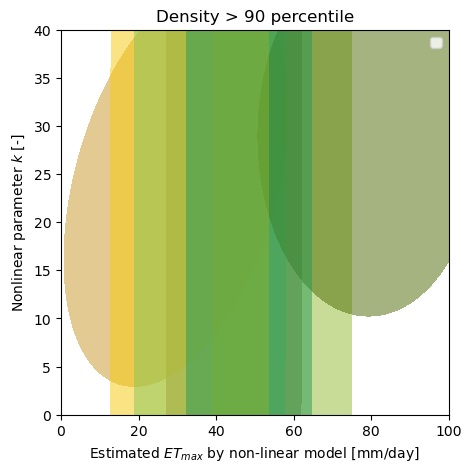

In [55]:
plot_2d_density(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_ETmax"],
    y_var=var_dict["sigmoid_k"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
    quantile=90,
    plot_logscale=False,
)

<ipython-input-54-be1af6d9928c>:27: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


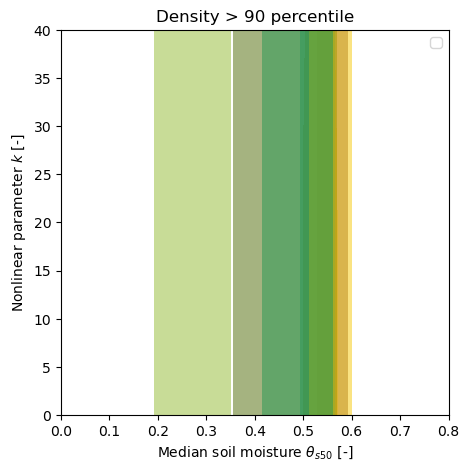

In [56]:
plot_2d_density(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_s50"],
    y_var=var_dict["sigmoid_k"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
    quantile=90,
    plot_logscale=False,
)

<ipython-input-54-be1af6d9928c>:27: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


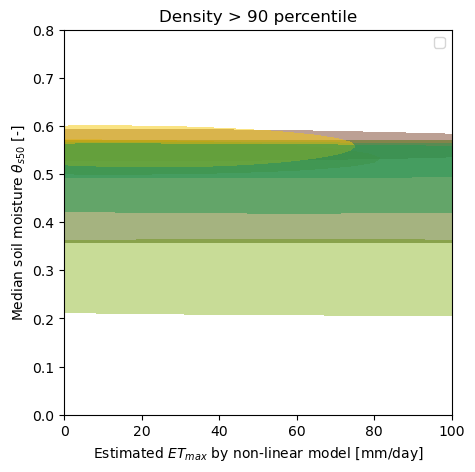

In [57]:
plot_2d_density(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_ETmax"],
    y_var=var_dict["sigmoid_s50"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
    quantile=90,
    plot_logscale=False,
)

In [58]:
def plot_pdf(df, x_var, z_var, cmap):
    fig, ax = plt.subplots(figsize=(4, 4))

    # Get unique bins
    bins_in_range = df[z_var["column_name"]].unique()
    bins_list = [bin for bin in bins_in_range if pd.notna(bin)]
    bin_sorted = sorted(bins_list, key=lambda x: x.left)

    # For each row in the subset, calculate the loss for a range of theta values
    for i, category in enumerate(bin_sorted):
        subset = df[df[z_var["column_name"]] == category]

        sns.kdeplot(
            subset[x_var["column_name"]],
            label=category,
            bw_adjust=0.5,
            color=plt.get_cmap(cmap)(i / len(bins_list)),
            cut=0,
            ax=ax,
        )

    # Set titles and labels
    plt.title(f"Kernel Density Estimation by {z_var['label']}")
    ax.set_xlabel(f"{x_var['label']} {x_var['unit']}")
    plt.ylabel("Density [-]")

    ax.set_xlim(x_var["lim"][0], x_var["lim"][1] * 2)

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

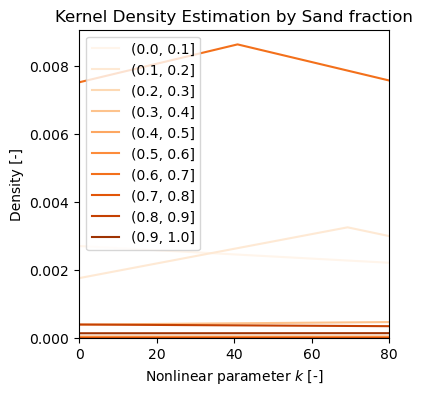

In [59]:
plot_pdf(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_k"],
    z_var=var_dict["sand_bins"],
    cmap=sand_cmap,
)

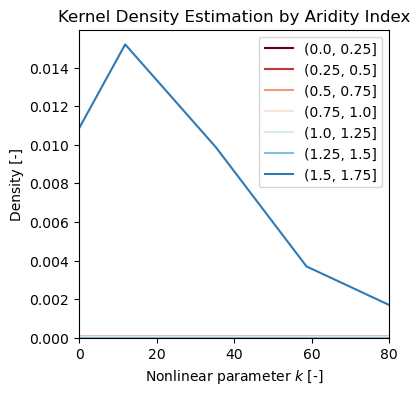

In [60]:
plot_pdf(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_k"],
    z_var=var_dict["ai_bins"],
    cmap=ai_cmap,
)

In [61]:
def plot_pdf_categorical(df, x_var, z_var, categories, colors):
    fig, ax = plt.subplots(figsize=(5, 5))
    for i, category in enumerate(categories):
        subset = df[df[z_var["column_name"]] == category]
        sns.kdeplot(
            subset[x_var["column_name"]],
            label=category,
            bw_adjust=0.5,
            color=colors[i],
            cut=0,
            ax=ax,
        )
    # Set titles and labels
    plt.title(f"Kernel Density Estimation by {z_var['label']}")
    ax.set_xlabel(f"{x_var['label']} {x_var['unit']}")
    plt.ylabel("Density [-]")

    ax.set_xlim(x_var["lim"][0], x_var["lim"][1] * 2)

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

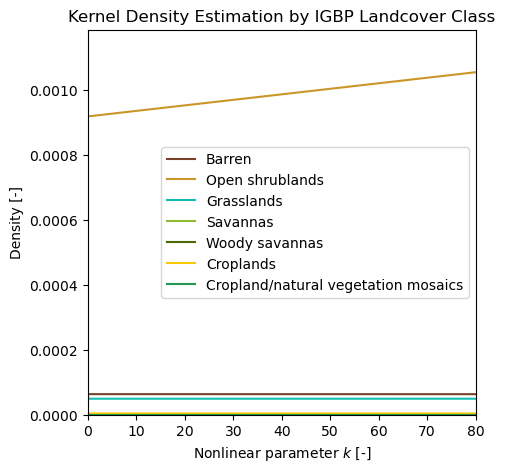

In [62]:
plot_pdf_categorical(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_k"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
)

In [63]:
from scipy.signal import find_peaks


def plot_histograms_with_mean_median(df, x_var, z_var, categories, colors):
    # Determine the number of rows needed for subplots based on the number of categories
    n_rows = len(categories)
    fig, axes = plt.subplots(n_rows, 1, figsize=(6, 3 * n_rows))

    if n_rows == 1:
        axes = [axes]  # Make it iterable even for a single category

    for i, (category, ax) in enumerate(zip(categories, axes)):
        subset = df[df[z_var["column_name"]] == category]

        # Determine bin edges based on bin interval
        bin_interval = 0.2
        min_edge = 0
        max_edge = 10
        bins = np.arange(min_edge, max_edge + bin_interval, bin_interval)

        # Plot histogram
        sns.histplot(
            subset[x_var["column_name"]],
            label=category,
            color=colors[i],
            bins=bins,  # You can adjust the number of bins
            kde=False,
            ax=ax,
        )

        # Calculate and plot mean and median lines
        mean_value = subset[x_var["column_name"]].mean()
        median_value = subset[x_var["column_name"]].median()
        ax.axvline(mean_value, color=colors[i], linestyle="--", lw=2, label="mean")
        ax.axvline(median_value, color=colors[i], linestyle="-", lw=2, label="median")

        # Detect and plot modes
        data = subset[x_var["column_name"]].dropna()
        kde = sns.kdeplot(data, bw_adjust=0.5, cut=0).get_lines()[0].get_data()
        # kde.clf()  # Clear the KDE plot
        peaks, _ = find_peaks(kde[1], distance=1)  # Adjust 'distance' as needed
        modes = kde[0][peaks]
        # for mode in modes[0]:
        ax.axvline(modes[0], color=colors[i], linestyle=":", lw=2, label="mode")

        # Set titles and labels for each subplot
        ax.set_title(f"{z_var['label']}: {category}")
        ax.set_xlabel(f"{x_var['label']} {x_var['unit']}")
        ax.set_ylabel("Frequency")

        ax.set_xlim(x_var["lim"][0], x_var["lim"][1] * 3)
        ax.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

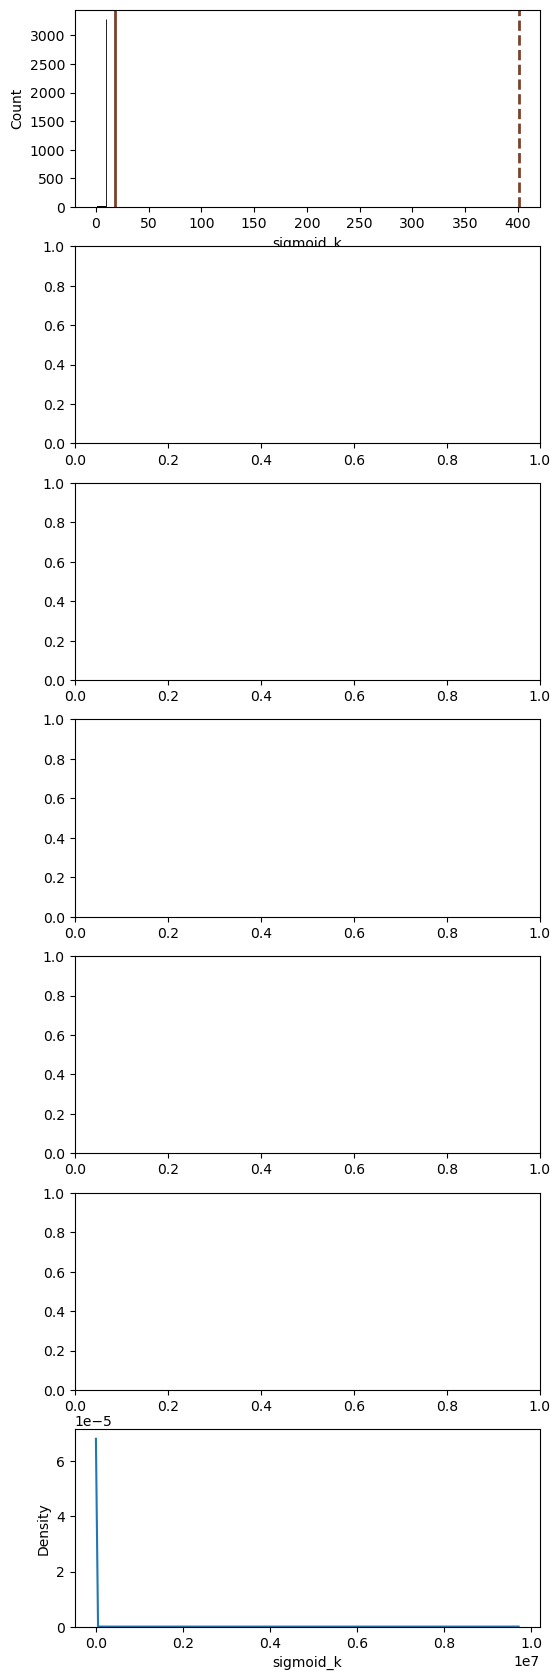

In [64]:
plot_histograms_with_mean_median(
    df=df_filt_sgm_2,
    x_var=var_dict["sigmoid_k"],
    z_var=var_dict["veg_class"],
    categories=vegetation_color_dict.keys(),
    colors=list(vegetation_color_dict.values()),
)